In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load live prediction file
df = pd.read_csv("phase6_live_predictions.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df.sort_values(["device_id", "timestamp"]).reset_index(drop=True)

print("Rows:", len(df))
print("Devices:", df["device_id"].unique())


Rows: 10686
Devices: ['EV_RICK_01' 'EV_SCOOT_01' 'EV_TAXI_01' 'NASA_B0005' 'NASA_B0043'
 'NASA_B0045' 'NASA_B0049' 'NASA_B0054']


Smooth Predictions (Reduce Noise)

In [4]:
SMOOTH_WINDOW = 5

df["soh_smooth"] = (
    df.groupby("device_id")["predicted_soh"]
    .rolling(SMOOTH_WINDOW, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df["rul_smooth"] = (
    df.groupby("device_id")["predicted_rul_cycles"]
    .rolling(SMOOTH_WINDOW, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


Detect Sudden SoH Drop

In [5]:
df["soh_change"] = (
    df.groupby("device_id")["soh_smooth"]
    .diff()
)

SOH_DROP_THRESHOLD = -0.01

df["soh_anomaly"] = df["soh_change"] < SOH_DROP_THRESHOLD


Detect Rapid RUL Decay

In [6]:
df["rul_change"] = (
    df.groupby("device_id")["rul_smooth"]
    .diff()
)

RUL_DROP_THRESHOLD = -3

df["rul_anomaly"] = df["rul_change"] < RUL_DROP_THRESHOLD


Low Health Detection

In [7]:
LOW_SOH_THRESHOLD = 0.8
LOW_RUL_THRESHOLD = 20

df["low_soh_flag"] = df["soh_smooth"] < LOW_SOH_THRESHOLD
df["low_rul_flag"] = df["rul_smooth"] < LOW_RUL_THRESHOLD


Risk Scoring Engine

In [8]:
df["risk_score"] = 0

df.loc[df["soh_anomaly"], "risk_score"] += 1
df.loc[df["rul_anomaly"], "risk_score"] += 1
df.loc[df["low_soh_flag"], "risk_score"] += 1
df.loc[df["low_rul_flag"], "risk_score"] += 1

def risk_level(score):
    if score == 0:
        return "Low"
    elif score <= 2:
        return "Medium"
    else:
        return "High"

df["risk_level"] = df["risk_score"].apply(risk_level)


Fleet Risk Summary

In [9]:
latest_status = (
    df.sort_values("timestamp")
      .groupby("device_id")
      .tail(1)
)

print("Latest Fleet Risk Status:")
print(latest_status[[
    "device_id",
    "soh_smooth",
    "rul_smooth",
    "risk_level"
]])


Latest Fleet Risk Status:
         device_id  soh_smooth  rul_smooth risk_level
2388   EV_SCOOT_01    0.954129  153.244977        Low
1211    EV_RICK_01    0.953608  153.102973        Low
3651    EV_TAXI_01    0.955363  153.335360        Low
9239    NASA_B0049    0.955363   49.698860        Low
6591    NASA_B0043    0.955363  224.893509        Low
5127    NASA_B0005    0.955363  476.466063        Low
7935    NASA_B0045    0.955363  163.559043        Low
10685   NASA_B0054    0.955363  199.018785        Low


Visualisation

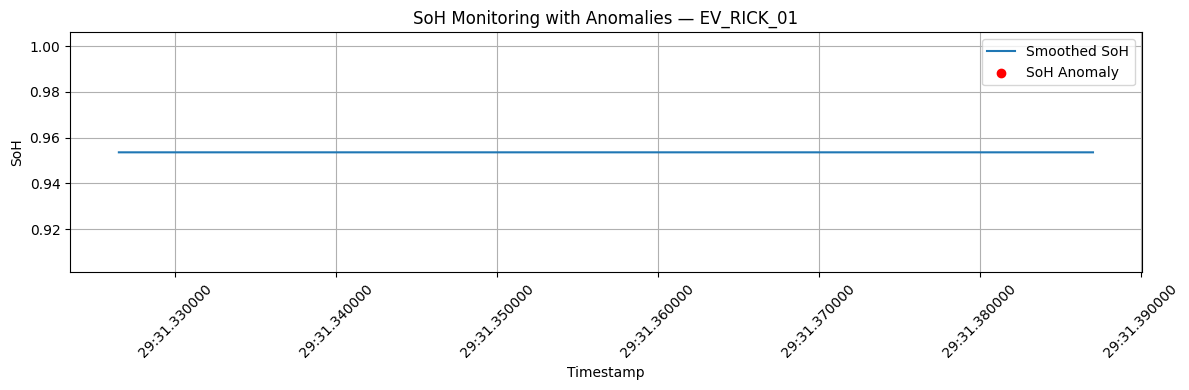

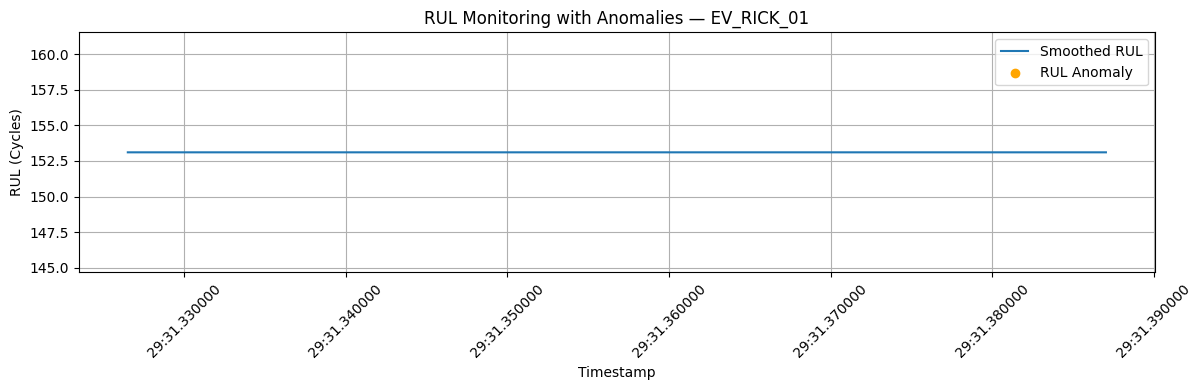

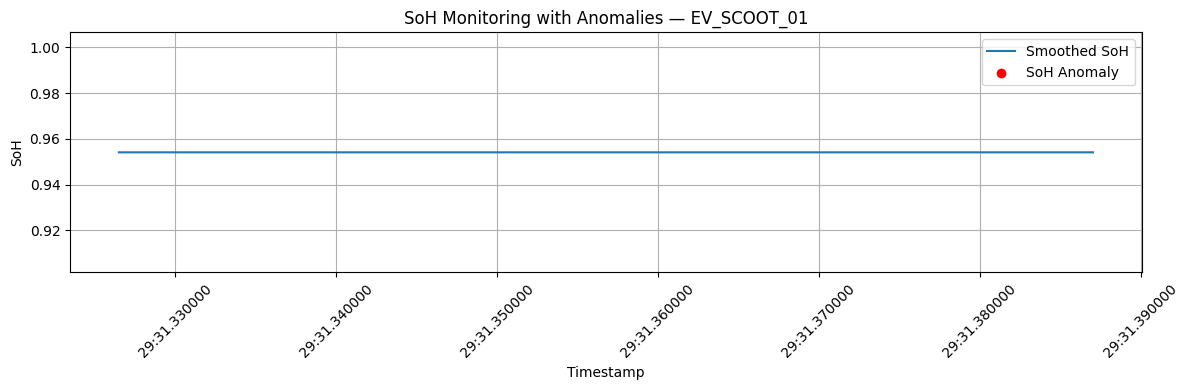

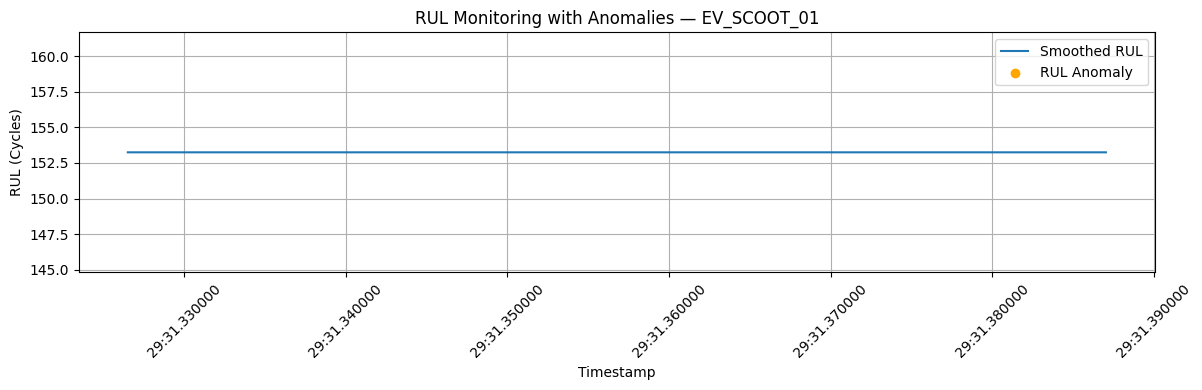

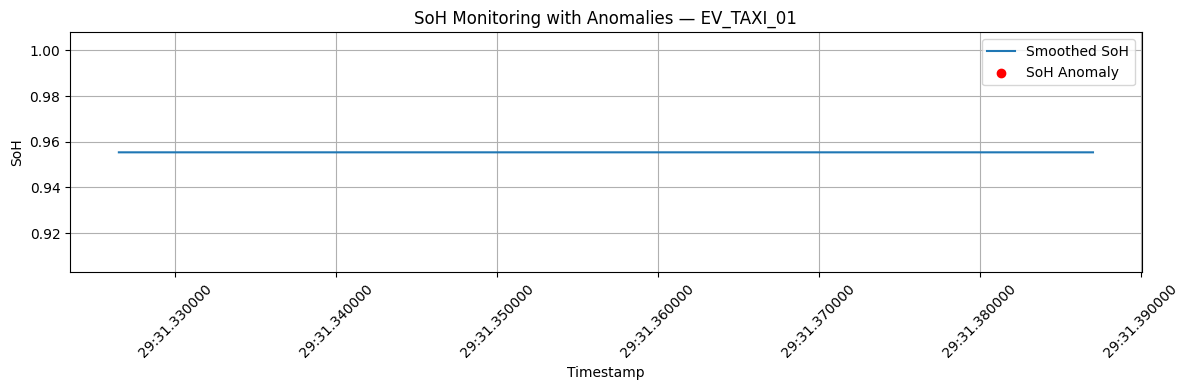

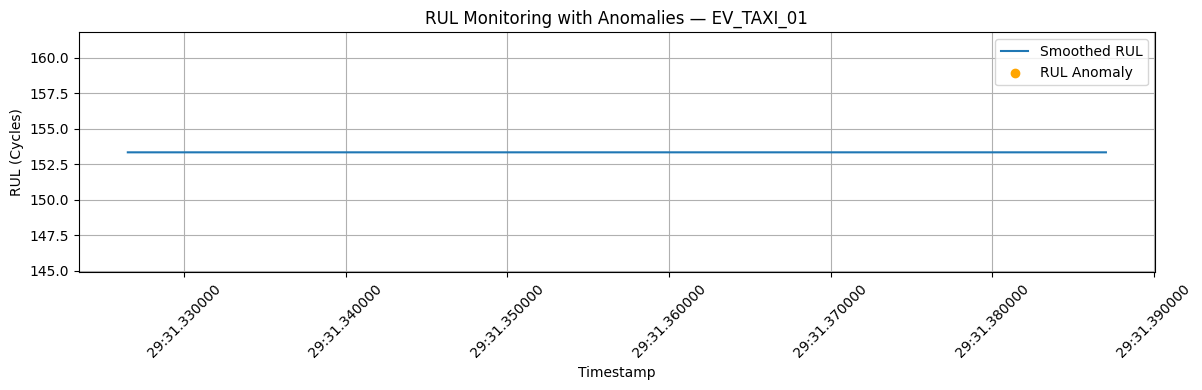

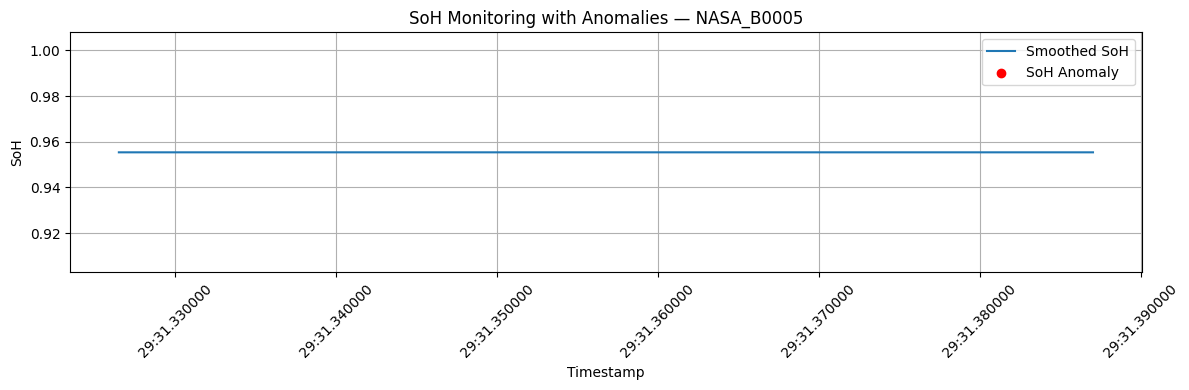

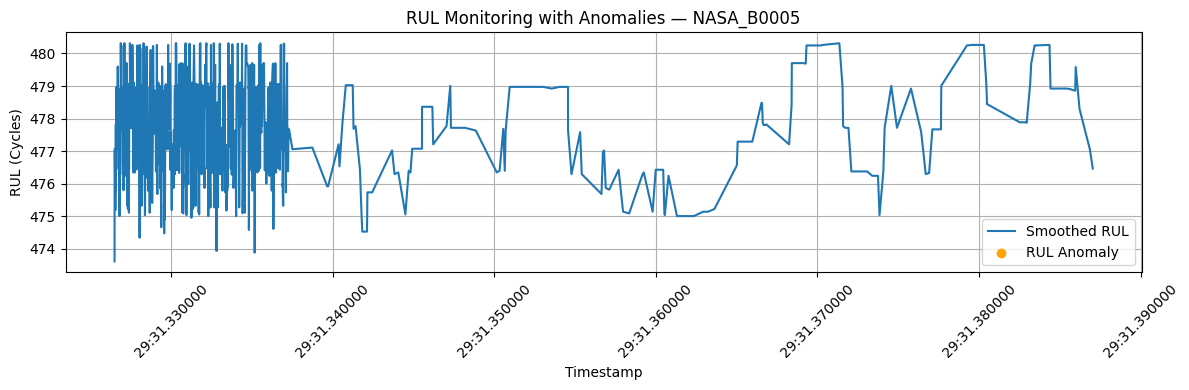

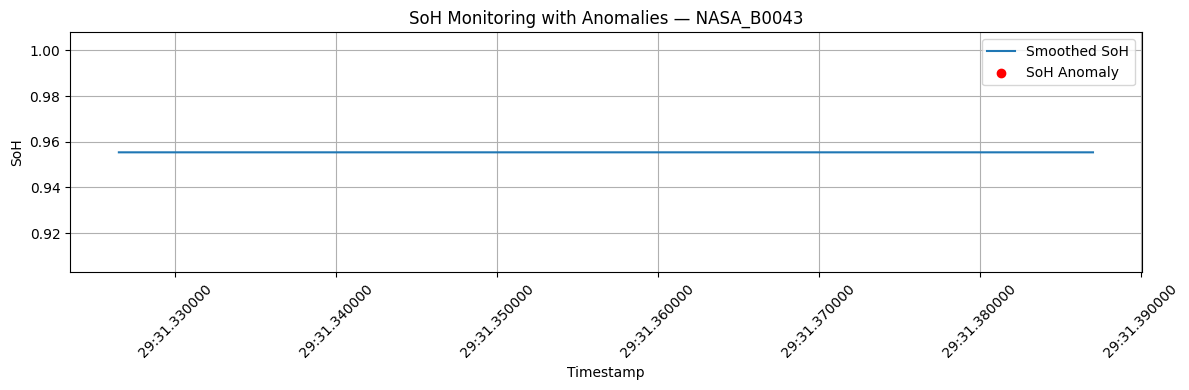

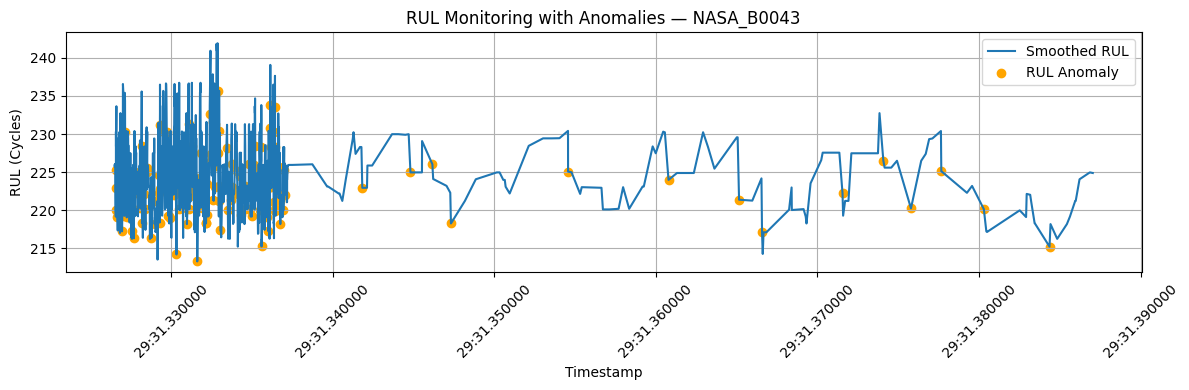

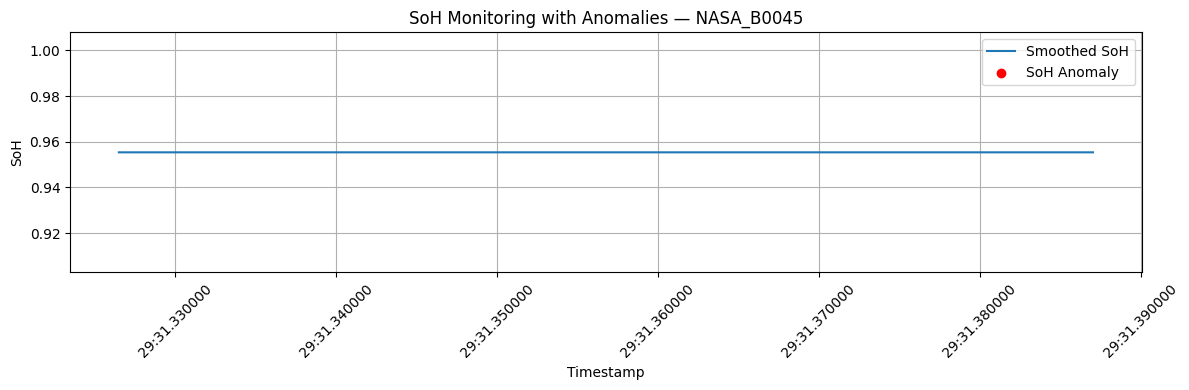

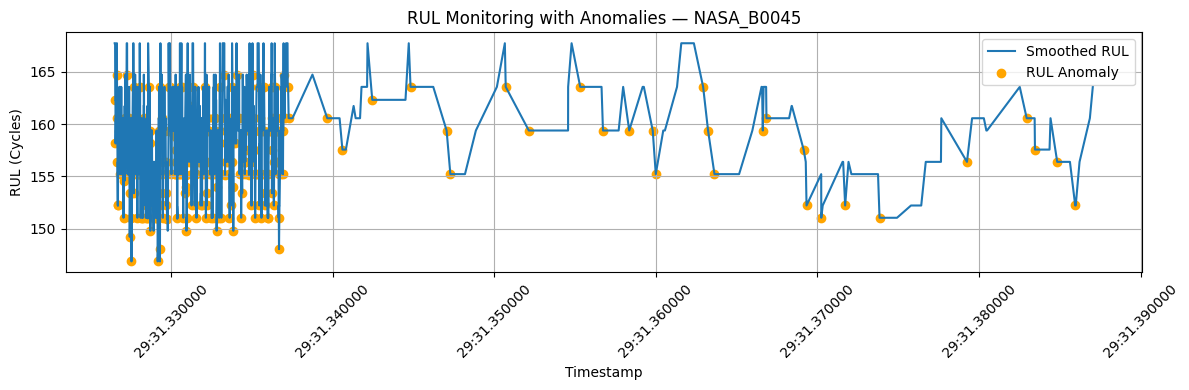

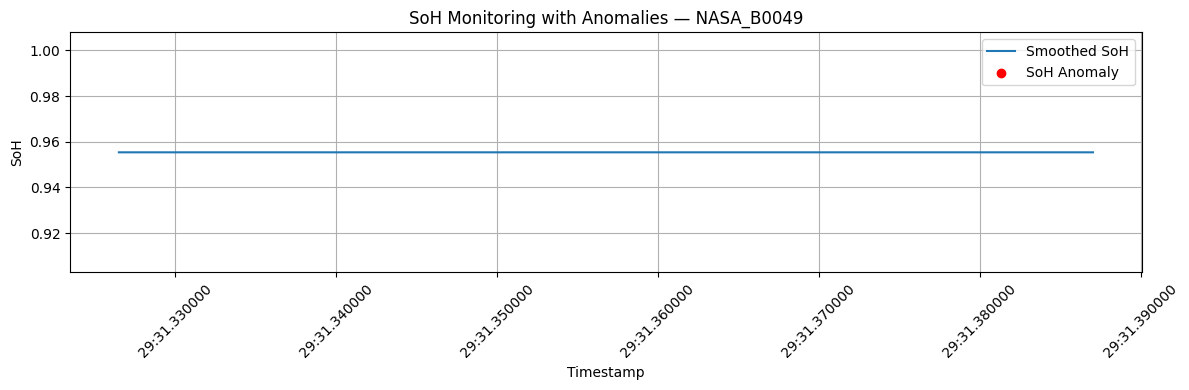

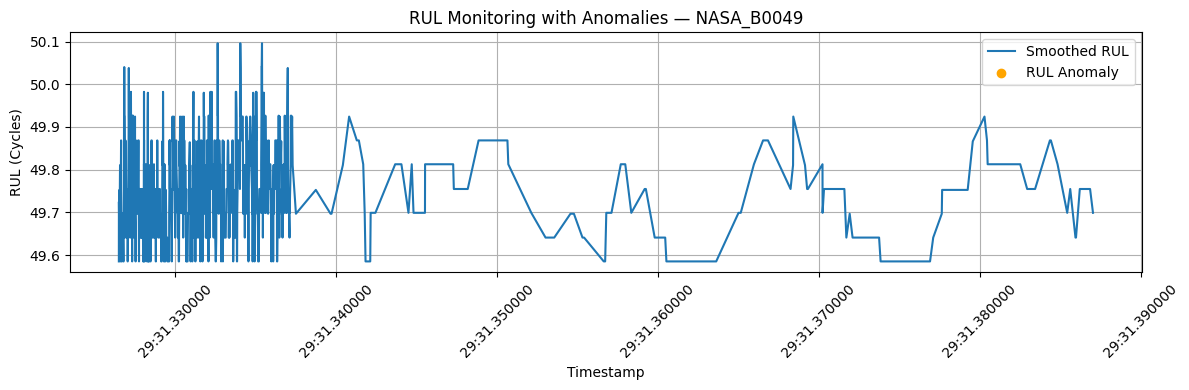

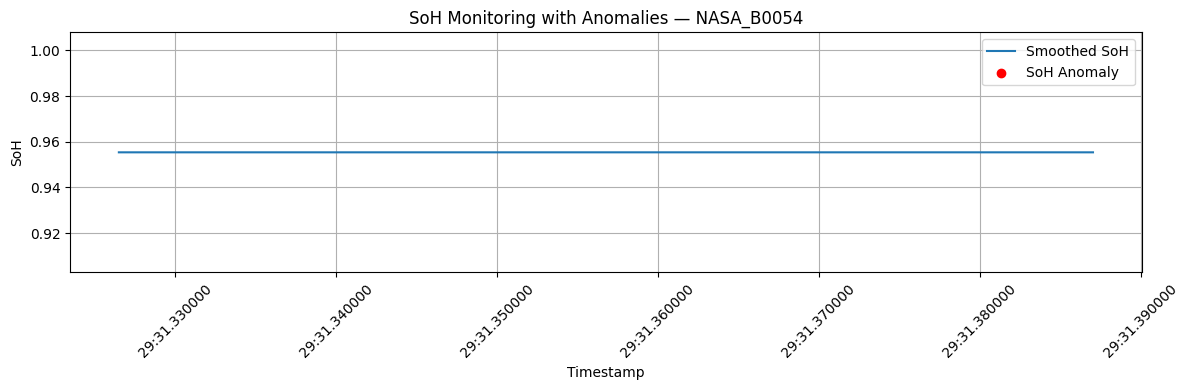

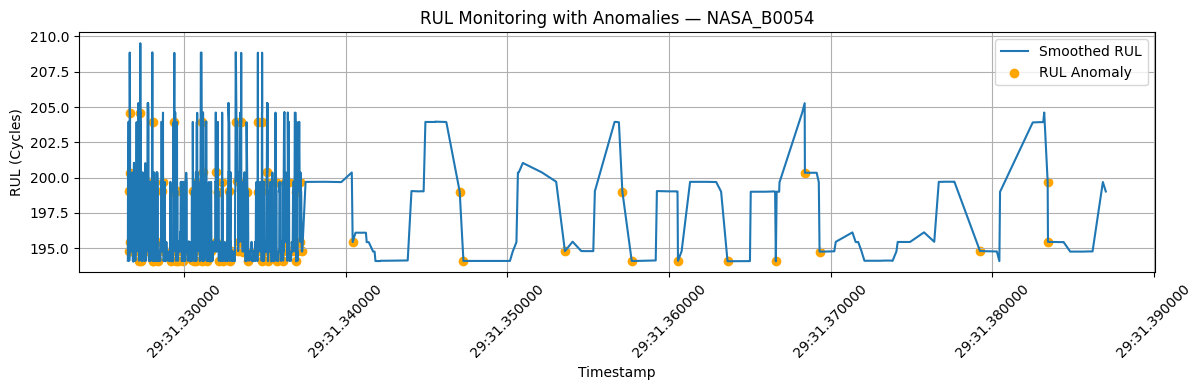

In [14]:
import matplotlib.pyplot as plt

devices = sorted(df["device_id"].unique())

for device_name in devices:

    device_df = df[df["device_id"] == device_name]

    # -------------------------
    # SoH Plot
    # -------------------------
    plt.figure(figsize=(12,4))

    plt.plot(device_df["timestamp"], device_df["soh_smooth"], label="Smoothed SoH")

    soh_anomaly_points = device_df[device_df["soh_anomaly"]]

    plt.scatter(
        soh_anomaly_points["timestamp"],
        soh_anomaly_points["soh_smooth"],
        color="red",
        label="SoH Anomaly"
    )

    plt.title(f"SoH Monitoring with Anomalies — {device_name}")
    plt.xlabel("Timestamp")
    plt.ylabel("SoH")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    # -------------------------
    # RUL Plot
    # -------------------------
    plt.figure(figsize=(12,4))

    plt.plot(device_df["timestamp"], device_df["rul_smooth"], label="Smoothed RUL")

    rul_anomaly_points = device_df[device_df["rul_anomaly"]]

    plt.scatter(
        rul_anomaly_points["timestamp"],
        rul_anomaly_points["rul_smooth"],
        color="orange",
        label="RUL Anomaly"
    )

    plt.title(f"RUL Monitoring with Anomalies — {device_name}")
    plt.xlabel("Timestamp")
    plt.ylabel("RUL (Cycles)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Fleet-Level Anomaly Count

In [17]:
print("\nAnomaly Counts Per Device:")
print(df.groupby("device_id")[[
    "soh_anomaly",
    "rul_anomaly",
    "low_soh_flag",
    "low_rul_flag"
]].sum())



Anomaly Counts Per Device:
             soh_anomaly  rul_anomaly  low_soh_flag  low_rul_flag
device_id                                                        
EV_RICK_01             0            0             0             0
EV_SCOOT_01            0            0             0             0
EV_TAXI_01             0            0             0             0
NASA_B0005             0            0             0             0
NASA_B0043             0          166             0             0
NASA_B0045             0          335             0             0
NASA_B0049             0            0             0             0
NASA_B0054             0          136             0             0


Save Phase 7 Output

In [18]:
df.to_csv("phase7_anomaly_output.csv", index=False)

print("Phase 7 anomaly file saved successfully.")


Phase 7 anomaly file saved successfully.
